In [167]:
import random
import numpy as np
import scipy.spatial
import matplotlib.pyplot as plt
import progressbar
%matplotlib inline


from scipy.stats import multivariate_normal
from scipy.stats import mvn
from scipy import integrate

In [228]:
# Some parameters for the program.
NUM_ITER = 100000
CLASSIFY_ROOT_RRT = False

This is the base class for the tree coloring problem. Both `RandomRecursiveTree` and `DaryTree` inherit from `ColoringTree`.

In [229]:
class ColoringTree(object):
    def __init__(self, k, h, num_iterations=NUM_ITER, init_color=None):
        assert(type(k) == int, "k should be an integer.")
        assert(k > 0, "k should exceed 0.")
        assert(type(h) == int, "h should be an integer.")
        assert(h > 0, "h should exceed 0.")

        self.k = k
        self.h = h

        if init_color:
            assert init_color in range(1, self.k + 1)
            self.root_color = init_color
        else:
            # Root color is chosen uniformly at random.
            self.root_color = random.randint(1, self.k)
        
        self.num_iterations = num_iterations
        self.urn_size = 1

<ipython-input-229-00f093215cb5>:3: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(type(k) == int, "k should be an integer.")
<ipython-input-229-00f093215cb5>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(k > 0, "k should exceed 0.")
<ipython-input-229-00f093215cb5>:5: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(type(h) == int, "h should be an integer.")
<ipython-input-229-00f093215cb5>:6: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(h > 0, "h should exceed 0.")


In [230]:
class LimitingFrequencyPlotter(object):
    """
    
    This class utilizes a dictionary data structure that resembles the urn dictionary,
    but tracks the movement of relative frequencies over all iterations in the algorithm.
    This allows us to plot results related to limiting relative frequencies, hence the name
    of the class.
    
    """
    
    def __init__(self, k, max_h):
        self.k = k
        self.max_h = max_h
        self.plotter_dict = {i: {j: 0 for j in range(1, self.k + 1)} for i in range(self.max_h + 1)}
        for i in range(self.max_h):
            for j in range(1, self.k + 1):
                self.plotter_dict[i][j] = []

        for j in range(1, self.k + 1):
            self.plotter_dict[self.max_h][j] = {} 
            self.plotter_dict[self.max_h][j]["rf"] = []
            self.plotter_dict[self.max_h][j]["total"] = 0

    def add_data(self, urn_dictionary, new_urn_height, new_urn_color, iter_cnt):
        for i in range(self.max_h):
            for j in range(1, self.k + 1):
                self.plotter_dict[i][j].append((urn_dictionary[i][j] * 1.)/iter_cnt)

        if new_urn_height >= self.max_h:
            self.plotter_dict[self.max_h][new_urn_color]["total"] += 1
        
        for j in range(1, self.k + 1):
            self.plotter_dict[self.max_h][j]["rf"].append(
                (self.plotter_dict[self.max_h][new_urn_color]["total"] * 1.)/iter_cnt
            )
    
    def plot(self, iter_cnt):
        """Add labels to the dominating frequencies for the final plot."""
        for i in range(self.max_h):
            for j in range(1, self.k + 1):
                plt.plot(range(iter_cnt), self.plotter_dict[i][j])

        for j in range(1, self.k + 1):
            plt.plot(
                range(iter_cnt),
                self.plotter_dict[self.max_h][j]["rf"],
                label="h > %d, Color %d" % (self.max_h, j)
            )

        plt.xlabel("Iterations")
        plt.ylabel("Relative Frequency of Nodes in Tree")
        plt.legend(loc='upper right')
        plt.show()


In [253]:
class RandomRecursiveTree(ColoringTree):

    def __init__(self, k, h, report_conf=False):
        self.report_conf = report_conf
        super(RandomRecursiveTree, self).__init__(k, h)            
        
        # Initialize urn data structure. Contains tuples (height, color). Place first ball in the urn.
        self.urn = [(0, self.root_color)]
        
        # The urn dictionary is indexed by (i, j), and contains the number of balls of
        # a particular color k at a particular height h.
        self.urn_dictionary = {i: {j: 0 for j in range(1, self.k + 1)} for i in range(self.h)}
        self.urn_dictionary[0][self.root_color] = 1

        # Used to compute confidence.
        self.parent_dictionary = {i: {j: 0 for j in range(1, self.k + 1)} for i in range(1, self.h + 1)}

    def simulate(self, limiting_freq_plot=False, limiting_freq_max_h=None, tvd_plot=False):
        
        assert(bool(limiting_freq_plot) == bool(limiting_freq_max_h),
            "Either both or neither of limiting_freq_plot and limiting_freq_h must be defined.")

        if limiting_freq_plot:
            plotter = LimitingFrequencyPlotter(self.k, limiting_freq_max_h)

        for i in range(1, self.num_iterations + 1):
            # Randomly pick a ball from the urn.
            urn_draw = random.randint(0, self.urn_size - 1)
            urn_height, urn_color = self.urn[urn_draw]

            # Generate a new ball. This essentially just defines the ball-replacement matrix,
            # and draws randomly.
            new_urn_height = urn_height + 1
            possible_new_urn_colors = [j for j in range(1, self.k + 1) if j != urn_color]
            new_urn_color = random.choice(possible_new_urn_colors)

            new_urn_ball = (new_urn_height, new_urn_color)
            self.urn.append(new_urn_ball)
            self.urn_dictionary[new_urn_height][new_urn_color] += 1

            self.parent_dictionary[new_urn_height][urn_color] += 1

            if limiting_freq_plot:
                plotter.add_data(self.urn_dictionary, new_urn_height, new_urn_color, i)

            self.urn_size += 1

        if limiting_freq_plot:
            plotter.plot(self.num_iterations)
        
        if tvd_plot:
            self.compile_tvd_statistics()

    def freq_at_level(self, h):
        """Helper method that retrieves relative frequencies from the urn."""
        colors_at_h = self.urn_dictionary[h].values()
        total_at_h = sum(colors_at_h)
        normalized_colors_at_h = (1.0 / total_at_h) * np.array(colors_at_h)    
        return normalized_colors_at_h
        
    def prediction_confidence(self, h):
        """
        Utilizes a multivariate normal approximation to compute confidence in a given
        prediction (from classify_root_from_level/Algorithm 1.6.2). See page 11.
        """
        mu = np.zeros(self.k)
        mu[self.root_color - 1] = 1

        b_h_inv = np.linalg.inv(np.linalg.matrix_power(self.markov_matrix(), h))
        colors_at_h = self.urn_dictionary[h].values()
        n_h = sum(colors_at_h)
        
        cov = np.zeros((self.k, self.k))
        for i in range(self.k):
            n_hi = self.parent_dictionary[h][i + 1]
            for j in range(self.k):
                n_hj = self.parent_dictionary[h][j + 1]
                if i == j:
                    cov[i][j] = (1. * ((self.k - 2) * (n_h - n_hi))) / ((n_h * (self.k - 1)) ** 2)
                else:
                    cov[i][j] = (-1. * (n_h - n_hi - n_hj)) / ((n_h * (self.k - 1)) ** 2)

        sigma = np.dot(np.dot(b_h_inv, cov), b_h_inv.T)

        if self.k == 2 or h == 1:
            # Since the covariance matrix is singular, the sampling
            # will fail. But the confidence is really 1.0 in this case.
            confidence = 1.0
        else:
            num_samples = 100000
            samples = np.random.multivariate_normal(mu, sigma, size=num_samples)
            argmax_samples = np.argmax(samples, axis=1)
            correct_predictions_samples = np.sum(argmax_samples == self.root_color - 1)  
            confidence = (1. * correct_predictions_samples) / num_samples

        return confidence
        
    def classify_root_from_level(self, h):
        """This is Algorithm 1.6.2 in the paper."""
        w_h = self.freq_at_level(h)
        v_0 = np.dot(np.linalg.inv(np.linalg.matrix_power(self.markov_matrix(), h)), w_h)
        prediction = np.argmax(v_0)
        
        if self.report_conf:
            confidence = self.prediction_confidence(h)
            return prediction + 1, confidence
        else:
            return prediction + 1

    def markov_matrix(self):
        # Construct the Markov transition probability matrix
        B = 1. / (self.k - 1) * np.ones((self.k, self.k))
        for i in range(self.k):
            B[i, i] = 0
        return B
        
    def theoretical_markov_approximation(self):
        theoretical_dist = np.zeros(self.k)
        theoretical_dist[self.root_color - 1] = 1
        uniform_dist = [1.0 / self.k] * self.k

        B = self.markov_matrix()

        total_variation_distances = []
        dists = []

        for h in range(self.h):
            dists.append(theoretical_dist)

            probability_matrix = np.array([theoretical_dist, uniform_dist])
            total_variation_distance = scipy.spatial.distance.pdist(probability_matrix, metric="euclidean")
            total_variation_distances.append(total_variation_distance[0])

            theoretical_dist = np.dot(B, theoretical_dist)

        return dists, total_variation_distances

    def compile_tvd_statistics(self):
        dists, total_variation_distances_theoretical = self.theoretical_markov_approximation()
        uniform_dist = [1.0 / self.k] * self.k

        total_variation_distances = []
        total_variation_distances_empirical_theoretical = []

        num_levels = 0
        for h in range(self.h):
            colors_at_h = self.urn_dictionary[h].values()
            total_at_h = sum(colors_at_h)

            if not h <= 1 and total_at_h < 100:
                break

            normalized_colors_at_h = (1.0 / total_at_h) * np.array(colors_at_h)
            probability_matrix = np.array([normalized_colors_at_h, uniform_dist])

            total_variation_distance = scipy.spatial.distance.pdist(probability_matrix, metric="euclidean")
            total_variation_distances.append(total_variation_distance[0])

            probability_matrix_empirical_theoretical = np.array([normalized_colors_at_h, dists[h]])
            total_variation_distance_empirical_theoretical = scipy.spatial.distance.pdist(probability_matrix_empirical_theoretical)
            total_variation_distances_empirical_theoretical.append(total_variation_distance_empirical_theoretical[0])

            num_levels += 1
            print "The total variation distance at height H = %d is %.4f" % (h, total_variation_distance)

        plt.plot(range(num_levels), total_variation_distances, color="red", label="Empirical")
        plt.plot(range(num_levels), total_variation_distances_theoretical[:num_levels], color="blue", label="Theoretical")
        plt.legend()
        plt.xlabel("Height (h)")
        plt.ylabel("Total Euclidean Variation Distance")
        plt.title("Total Variation Distance to Uniformity")
        plt.show()

        plt.plot(range(num_levels), total_variation_distances_empirical_theoretical)
        plt.xlabel("Height (h)")
        plt.ylabel("Total Euclidean Variation Distance")
        plt.title("Total Variation Distance between Theoretical and Empirical")
        plt.show()


<ipython-input-253-d2003bd2378b>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(bool(limiting_freq_plot) == bool(limiting_freq_max_h),


In [254]:
class daryTree(ColoringTree):
    
    def __init__(self, d, k, h):
        assert(d >= 1 and type(d) == int, "d must be an integer exceeding 0")
        self.d = d

        super(daryTree, self).__init__(k, h)

        # Initialize (external node) urn data structure. Contains tuples (height, color). Place first ball in the urn.
        self.external_nodes = [(1, self.root_color) for i in range(self.d)]
        self.external_nodes_size = d

        # Initialize (internal node) urn data structure. Contains tuples (height, color). Place first ball in the urn.
        self.urn = [(0, self.root_color)]

        # The urn dictionary is indexed by (i, j), and contains the number of balls of
        # a particular color k at a particular height h.
        self.internal_node_dictionary = {i: {j: 0 for j in range(1, self.k + 1)} for i in range(self.h)}
        self.internal_node_dictionary[0][self.root_color] = 1

    def simulate(self, limiting_freq_plot=False, limiting_freq_max_h=None, tvd_plot=False):

        assert(bool(limiting_freq_plot) == bool(limiting_freq_max_h),
        "Either both or neither of limiting_freq_plot and limiting_freq_h must be defined.")

        if limiting_freq_plot:
            plotter = LimitingFrequencyPlotter(self.k, limiting_freq_max_h)

        for i in range(1, self.num_iterations + 1):
            if i % 10000 == 0:
                print("Finished iteration %d" % i)

            # Randomly pick a ball from the urn.
            urn_draw = random.randint(0, self.external_nodes_size - 1)
            external_urn_draw = self.external_nodes[urn_draw]
            urn_height, urn_color = external_urn_draw

            # Generate a new ball. This essentially just defines the ball-replacement matrix,
            # and draws randomly.
            possible_new_urn_colors = [j for j in range(1, self.k + 1) if j != urn_color]
            new_urn_color = random.choice(possible_new_urn_colors)

            new_urn_ball = (urn_height, new_urn_color)
            self.urn.append(new_urn_ball)
            self.internal_node_dictionary[urn_height][new_urn_color] += 1

            new_external_urn_height = urn_height + 1
            new_external_urn_balls = [(new_external_urn_height, new_urn_color) for j in range(self.d)]
            self.external_nodes.remove(external_urn_draw)
            self.external_nodes.extend(new_external_urn_balls)
    
            if limiting_freq_plot:
                plotter.add_data(self.internal_node_dictionary, urn_height, new_urn_color, i)

            self.urn_size += 1
            self.external_nodes_size += (self.d - 1)

        if limiting_freq_plot:
            plotter.plot(self.num_iterations)
        
        if tvd_plot:
            self.compile_tvd_statistics()

    def compile_tvd_statistics(self):
        uniform_dist = [1.0 / self.k] * self.k

        total_variation_distances = []
        total_variation_distances_empirical_theoretical = []

        num_levels = 0
        for h in range(self.h):
            colors_at_h = self.internal_node_dictionary[h].values()
            total_at_h = sum(colors_at_h)

            if not h <= 1 and total_at_h <= 1:
                break

            normalized_colors_at_h = (1.0 / total_at_h) * np.array(colors_at_h)
            probability_matrix = np.array([normalized_colors_at_h, uniform_dist])

            total_variation_distance = scipy.spatial.distance.pdist(probability_matrix, metric="euclidean")
            total_variation_distances.append(total_variation_distance[0])

            num_levels += 1
            print "The total variation distance at height H = %d is %.4f" % (h, total_variation_distance)

        plt.plot(range(num_levels), total_variation_distances, color="red", label="Empirical")
        plt.xlabel("Height (h)")
        plt.ylabel("Total Euclidean Variation Distance")
        plt.title("Total Variation Distance to Uniformity")
        plt.show()

<ipython-input-254-836cd896357a>:4: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(d >= 1 and type(d) == int, "d must be an integer exceeding 0")
<ipython-input-254-836cd896357a>:23: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(bool(limiting_freq_plot) == bool(limiting_freq_max_h),


Utilize the `RandomRecursiveTree` class to perform meaningful simulations.

1. Limiting frequencies plot.
2. TVD plots for Markov Chain "approximation."
3. Root classification.

Running iteration 10000
Running iteration 20000
Running iteration 30000
Running iteration 40000
Running iteration 50000
Running iteration 60000
Running iteration 70000
Running iteration 80000
Running iteration 90000
Running iteration 100000


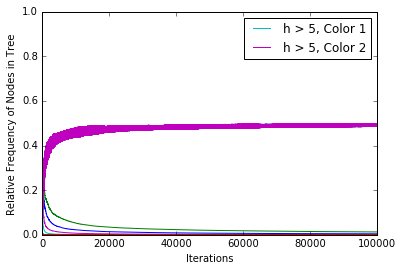

In [83]:
two_color_rrt = RandomRecursiveTree(2, 100)
limiting_freq_sim = two_color_rrt.simulate(limiting_freq_plot=True, limiting_freq_max_h=5)

Running iteration 10000
Running iteration 20000
Running iteration 30000
Running iteration 40000
Running iteration 50000
Running iteration 60000
Running iteration 70000
Running iteration 80000
Running iteration 90000
Running iteration 100000


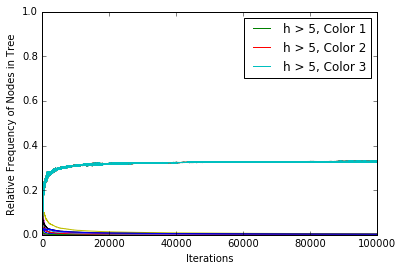

In [73]:
three_color_rrt = RandomRecursiveTree(3, 100)
limiting_freq_sim = three_color_rrt.simulate(limiting_freq_plot=True, limiting_freq_max_h=5)

Running iteration 10000
Running iteration 20000
Running iteration 30000
Running iteration 40000
Running iteration 50000
Running iteration 60000
Running iteration 70000
Running iteration 80000
Running iteration 90000
Running iteration 100000
Running iteration 110000
Running iteration 120000
Running iteration 130000
Running iteration 140000
Running iteration 150000
Running iteration 160000
Running iteration 170000
Running iteration 180000
Running iteration 190000
Running iteration 200000
Running iteration 210000
Running iteration 220000
Running iteration 230000
Running iteration 240000
Running iteration 250000
Running iteration 260000
Running iteration 270000
Running iteration 280000
Running iteration 290000
Running iteration 300000
Running iteration 310000
Running iteration 320000
Running iteration 330000
Running iteration 340000
Running iteration 350000
Running iteration 360000
Running iteration 370000
Running iteration 380000
Running iteration 390000
Running iteration 400000
Running i

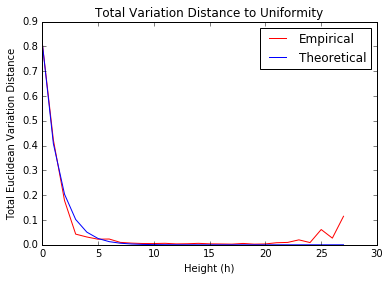

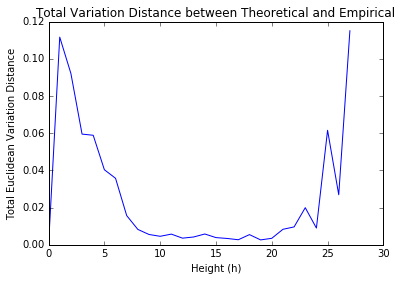

In [92]:
three_color_rrt = RandomRecursiveTree(3, 100)
tvd_sim = three_color_rrt.simulate(tvd_plot=True)

Running iteration 10000
Running iteration 20000
Running iteration 30000
Running iteration 40000
Running iteration 50000
Running iteration 60000
Running iteration 70000
Running iteration 80000
Running iteration 90000
Running iteration 100000
Running iteration 110000
Running iteration 120000
Running iteration 130000
Running iteration 140000
Running iteration 150000
Running iteration 160000
Running iteration 170000
Running iteration 180000
Running iteration 190000
Running iteration 200000
Running iteration 210000
Running iteration 220000
Running iteration 230000
Running iteration 240000
Running iteration 250000
Running iteration 260000
Running iteration 270000
Running iteration 280000
Running iteration 290000
Running iteration 300000
Running iteration 310000
Running iteration 320000
Running iteration 330000
Running iteration 340000
Running iteration 350000
Running iteration 360000
Running iteration 370000
Running iteration 380000
Running iteration 390000
Running iteration 400000
Running i

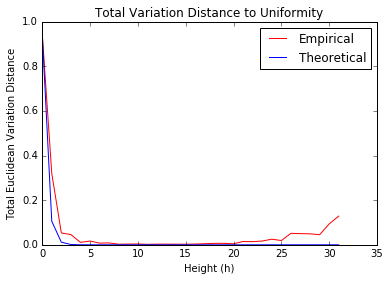

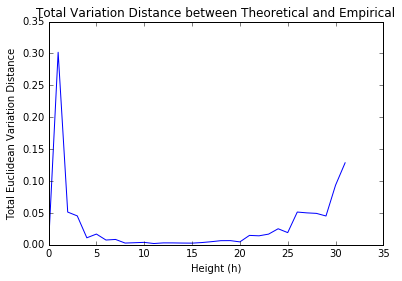

In [93]:
ten_color_rrt = RandomRecursiveTree(10, 100)
tvd_sim = ten_color_rrt.simulate(tvd_plot=True)

In [110]:
# This is one of the longer running scripts.
accuracy_list = []
num_samples = 100

for k in range(4, 5):
    for h in range(1, 10):
        correct = 0
        confidence_values = []
        bar = progressbar.ProgressBar()
        for i in bar(range(num_samples)):
            k_color_rrt = RandomRecursiveTree(k, 100, report_conf=True)
            k_color_rrt.simulate()
            classification, confidence = k_color_rrt.classify_root_from_level(h)
            confidence_values.append(confidence)
            if classification == k_color_rrt.root_color:
                correct += 1

        confidence_average = np.mean(np.array(confidence_values))
        accuracy_list.append((k, h, (correct * 1.)/num_samples, confidence_average))

100% (100 of 100) |#######################| Elapsed Time: 0:10:57 Time: 0:10:57
100% (100 of 100) |#######################| Elapsed Time: 0:11:04 Time: 0:11:04
100% (100 of 100) |#######################| Elapsed Time: 0:10:34 Time: 0:10:34
100% (100 of 100) |#######################| Elapsed Time: 0:16:22 Time: 0:16:22
100% (100 of 100) |#######################| Elapsed Time: 0:17:20 Time: 0:17:20
100% (100 of 100) |#######################| Elapsed Time: 0:14:39 Time: 0:14:39
100% (100 of 100) |#######################| Elapsed Time: 0:11:57 Time: 0:11:57
100% (100 of 100) |#######################| Elapsed Time: 0:14:04 Time: 0:14:04
100% (100 of 100) |#######################| Elapsed Time: 0:14:28 Time: 0:14:28


In [112]:
print accuracy_list

[(4, 1, 0.97, 1.0), (4, 2, 0.76, 0.84149889999999994), (4, 3, 0.46, 0.71868750000000015), (4, 4, 0.49, 0.54373300000000002), (4, 5, 0.34, 0.39937290000000003), (4, 6, 0.28, 0.32295649999999992), (4, 7, 0.34, 0.28163350000000004), (4, 8, 0.24, 0.26320389999999999), (4, 9, 0.35, 0.25511040000000001)]


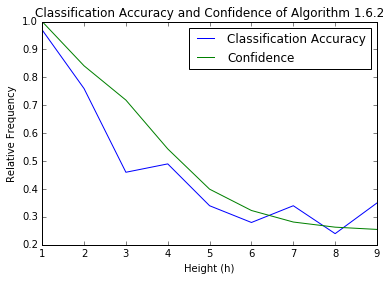

In [129]:
k_list, h_list, acc_list, conf_list = zip(*accuracy_list)
plt.plot(h_list, acc_list, color="blue", label="Classification Accuracy")
plt.plot(h_list, conf_list, color="green", label="Confidence")
plt.xlabel("Height (h)")
plt.ylabel("Relative Frequency")
plt.title("Classification Accuracy and Confidence of Algorithm 1.6.2")
plt.legend()
plt.show()

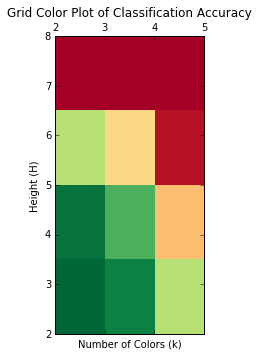

In [137]:
original_accuracy_list = [
    (2, 2, 1.0, 1.0),
    (2, 5, 1.0, 1.0),
    (2, 8, 1.0, 1.0),
    (3, 2, 0.97, 0.99368529999999977),
    (3, 5, 0.7, 0.98770829999999998),
    (3, 8, 0.48, 0.69833870000000009),
    (4, 2, 0.74, 0.84456799999999987),
    (4, 5, 0.35, 0.4027696999999999),
    (4, 8, 0.24, 0.26326249999999995),
    (5, 2, 0.48, 0.61759680000000006),
    (5, 5, 0.26, 0.232075),
    (5, 8, 0.22, 0.20147180000000003)
]

matrix_viz = np.zeros((4, 3))
for entry in original_accuracy_list:
    k, h, acc, conf = entry
    if h == 2:
        matrix_viz[k - 2][2] = acc
    elif h == 5:
        matrix_viz[k - 2][1] = acc
    else:
        matrix_viz[k - 2][0] = acc

# How can I label the axes in matshow
plt.matshow(matrix_viz, cmap="RdYlGn_r", extent=[2, 5, 2, 8])
plt.xlabel("Number of Colors (k)")
plt.ylabel("Height (H)")
plt.title("Grid Color Plot of Classification Accuracy")

Utilize the `daryTree` class to perform meaningful simulations.
1. Limiting frequencies plot.
2. TVD plots - "distance to uniformity"


Running iteration 10000


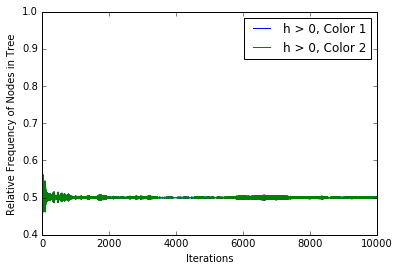

In [213]:
two_color_two_ary = daryTree(2, 2, 100)
limiting_freq_sim = two_color_two_ary.simulate(limiting_freq_plot=True, limiting_freq_max_h=0)

Running iteration 10000


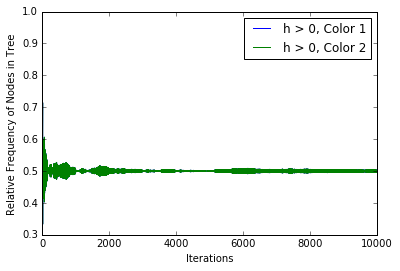

In [214]:
two_color_ten_ary = daryTree(10, 2, 100)
limiting_freq_sim = two_color_ten_ary.simulate(limiting_freq_plot=True, limiting_freq_max_h=0)

Running iteration 10000


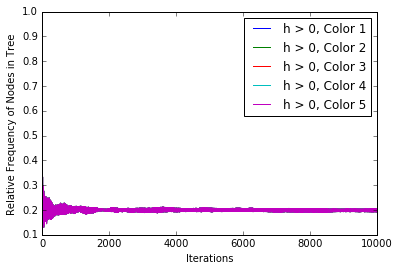

In [215]:
five_color_two_ary = daryTree(2, 5, 100)
limiting_freq_sim = five_color_two_ary.simulate(limiting_freq_plot=True, limiting_freq_max_h=0)

Running iteration 10000


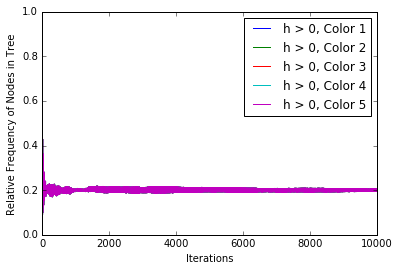

In [217]:
five_color_ten_ary = daryTree(10, 5, 100)
limiting_freq_sim = five_color_ten_ary.simulate(limiting_freq_plot=True, limiting_freq_max_h=0)

The total variation distance at height H = 0 is 0.7071
The total variation distance at height H = 1 is 0.7071
The total variation distance at height H = 2 is 0.7071
The total variation distance at height H = 3 is 0.7071
The total variation distance at height H = 4 is 0.7071
The total variation distance at height H = 5 is 0.7071
The total variation distance at height H = 6 is 0.7071
The total variation distance at height H = 7 is 0.7071
The total variation distance at height H = 8 is 0.7071
The total variation distance at height H = 9 is 0.7071
The total variation distance at height H = 10 is 0.7071
The total variation distance at height H = 11 is 0.7071
The total variation distance at height H = 12 is 0.7071
The total variation distance at height H = 13 is 0.7071
The total variation distance at height H = 14 is 0.7071
The total variation distance at height H = 15 is 0.7071
The total variation distance at height H = 16 is 0.7071
The total variation distance at height H = 17 is 0.7071
Th

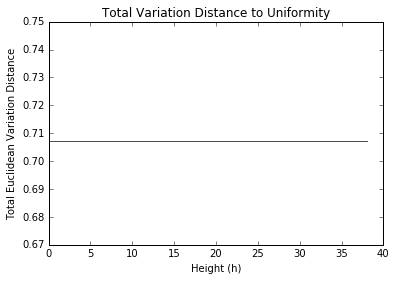

In [246]:
two_color_two_ary = daryTree(2, 2, 100)
limiting_freq_sim = two_color_two_ary.simulate(tvd_plot=True)

Finished iteration 10000
Finished iteration 20000
Finished iteration 30000
Finished iteration 40000
Finished iteration 50000
Finished iteration 60000
Finished iteration 70000
Finished iteration 80000
Finished iteration 90000
Finished iteration 100000
> <ipython-input-250-86a8b29eb782>(65)compile_tvd_statistics()
-> uniform_dist = [1.0 / self.k] * self.k
(Pdb) c
The total variation distance at height H = 0 is 0.7071
The total variation distance at height H = 1 is 0.7071
The total variation distance at height H = 2 is 0.7071
The total variation distance at height H = 3 is 0.7071
The total variation distance at height H = 4 is 0.7071
The total variation distance at height H = 5 is 0.7071
The total variation distance at height H = 6 is 0.7071
The total variation distance at height H = 7 is 0.7071
The total variation distance at height H = 8 is 0.7071
The total variation distance at height H = 9 is 0.7071
The total variation distance at height H = 10 is 0.7071
The total variation distance a

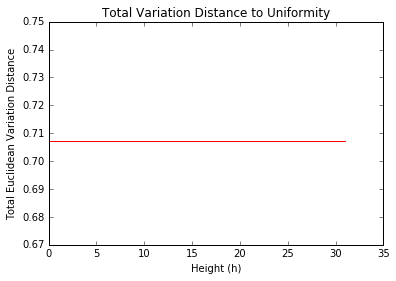

In [255]:
three_color_ten_ary = daryTree(10, 3, 100)
tvd_sim = two_color_ten_ary.simulate(tvd_plot=True)

Finished iteration 10000
Finished iteration 20000
Finished iteration 30000
Finished iteration 40000
Finished iteration 50000
Finished iteration 60000
Finished iteration 70000
Finished iteration 80000
Finished iteration 90000
Finished iteration 100000
The total variation distance at height H = 0 is 0.8944
The total variation distance at height H = 1 is 0.5477
The total variation distance at height H = 2 is 0.4183
The total variation distance at height H = 3 is 0.2850
The total variation distance at height H = 4 is 0.3236
The total variation distance at height H = 5 is 0.2006
The total variation distance at height H = 6 is 0.1178
The total variation distance at height H = 7 is 0.0639
The total variation distance at height H = 8 is 0.0873
The total variation distance at height H = 9 is 0.0625
The total variation distance at height H = 10 is 0.0530
The total variation distance at height H = 11 is 0.0283
The total variation distance at height H = 12 is 0.0146
The total variation distance at

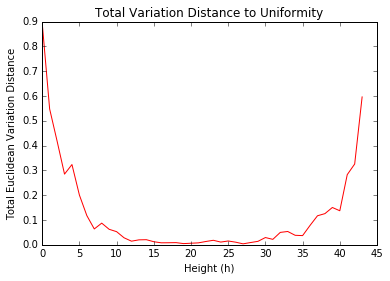

In [256]:
five_color_two_ary = daryTree(2, 5, 100)
tvd_sim = five_color_two_ary.simulate(tvd_plot=True)

Finished iteration 10000
Finished iteration 20000
Finished iteration 30000
Finished iteration 40000
Finished iteration 50000
Finished iteration 60000
Finished iteration 70000
Finished iteration 80000
Finished iteration 90000
Finished iteration 100000
The total variation distance at height H = 0 is 0.8944
The total variation distance at height H = 1 is 0.3354
The total variation distance at height H = 2 is 0.1091
The total variation distance at height H = 3 is 0.0226
The total variation distance at height H = 4 is 0.0372
The total variation distance at height H = 5 is 0.0270
The total variation distance at height H = 6 is 0.0198
The total variation distance at height H = 7 is 0.0162
The total variation distance at height H = 8 is 0.0106
The total variation distance at height H = 9 is 0.0152
The total variation distance at height H = 10 is 0.0162
The total variation distance at height H = 11 is 0.0072
The total variation distance at height H = 12 is 0.0026
The total variation distance at

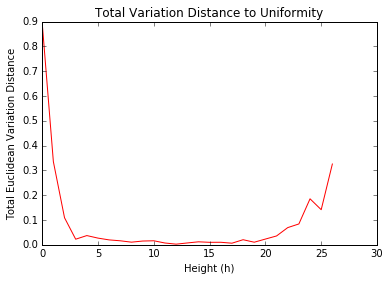

In [257]:
five_color_ten_ary = daryTree(10, 5, 100)
tvd_sim = five_color_ten_ary.simulate(tvd_plot=True)